Importing modules

In [627]:
reset -fs

# Importing modules

In [628]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor,AdaBoostClassifier
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## Loading and cleaning the data

In [535]:
df = pd.read_excel('Drug_Risk.xls')
df.columns = [c.lower() for c in df.columns]

Dropping rows where people said they used Semer, since it is a fictional drug. Dropping the column ID

In [536]:
df = df.drop(df[df.semer !='CL0'].index)
df.pop('id')
df.pop('semer')
df.ss.head()

0   -1.18084
1   -0.21575
2    0.40148
3   -1.18084
4   -0.21575
Name: ss, dtype: float64

## setting up dictionaries

In [537]:
df.age = df.age.replace(to_replace={-0.95197: '18to24',-0.07854: '25to34',0.49788: '35to44',1.09449: '45to54',1.82213: '55to64',2.59171: '65plus'})

In [538]:
df.gender = df.gender.replace(to_replace={0.48246:'Female',-0.48246: 'Male'})

In [539]:
df.education = df.education.replace(to_replace = {-2.43591: 'Left school',-1.73790: 'Left school',-1.43719: 'Left school at 17 years',
                                                  -1.22751: 'Left school at 18 years',-0.61113: 'Some college or university, no certificate or degree',
                                                  -0.05921: 'Professional certificate/ diploma', 0.45468: 'University degree',1.16365: 'Masters degree', 1.98437: 'Doctorate degree'})

In [540]:
df.country = df.country.replace(to_replace={-0.09765: 'Australia',0.24923: 'Canada', -0.46841: 'New Zealand',
                                            -0.28519: 'Other',0.21128: 'Republic of Ireland',0.96082: 'UK',
                                            -0.57009: 'USA'})

In [541]:
df.ethnicity = df.ethnicity.replace(to_replace = {-0.50212:'Asian',-1.10702: 'Black',1.90725: 'Mixed-Black/Asian',
                                                  0.12600: 'Mixed-White/Asian',-0.22166 :'Mixed-White/Black',
                                                  0.11440: 'Other',-0.31685: 'White'})

In [542]:
drugs= ['alcohol', 'amphet', 'amyl', 'benzos','caff','cannabis', 'choc', 'coke', 'crack', 'ecstasy',
        'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'shrooms','nicotine','vsa']

### Dummies for first five

In [543]:
first_five = ['age','gender','education','country','ethnicity']
for i in first_five:
    globals()["dummies_" + str(i)] = pd.get_dummies(df[i], drop_first=True, dtype=None)
    df = df.join(globals()["dummies_" + str(i)],rsuffix='dummy_')
    

In [544]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1877 entries, 0 to 1884
Data columns (total 55 columns):
age                                                     1877 non-null object
gender                                                  1877 non-null object
education                                               1877 non-null object
country                                                 1877 non-null object
ethnicity                                               1877 non-null object
nscore                                                  1877 non-null float64
escore                                                  1877 non-null float64
oscore                                                  1877 non-null float64
ascore                                                  1877 non-null float64
cscore                                                  1877 non-null float64
impulsive                                               1877 non-null float64
ss                                      

## Changing  use of drugs to classification

In [545]:
for i in range(len(drugs)):
    df[drugs[i]] = df[drugs[i]].replace('CL0',0).replace('CL1',0).replace('CL2',0).replace('CL3',1).replace('CL4',1).replace('CL5',1).replace('CL6',1)
    

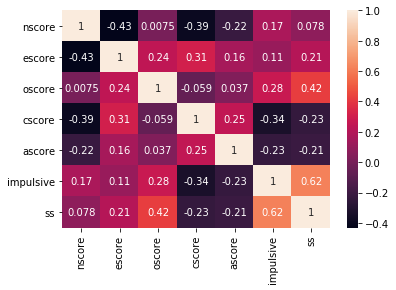

In [546]:
df_corr = pd.DataFrame(df,columns=['nscore','escore','oscore','cscore','ascore','impulsive','ss'])

corrMatrix = df_corr.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [547]:
soft_drugs = [ 'alcohol','caff','choc', 'nicotine']
middle_drugs = [ 'amyl','cannabis', 'ecstasy', 'ketamine', 'lsd','legalh','shrooms','vsa']
hard_drugs =  ['amphet','benzos', 'coke', 'crack', 'heroin', 'meth']

In [548]:
cat_features = ['age','gender','education','country','ethnicity','alcohol','amphet', 'amyl', 'benzos', 'caff',
                'cannabis', 'choc', 'coke', 'crack', 'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd','meth',
                'shrooms', 'nicotine', 'vsa']

In [549]:
df[cat_features]= df[cat_features].astype('category')

In [550]:
num_features = list(df.columns[df.dtypes==float])

## Train test split

In [611]:
for d in df.columns:
    X = df.drop(d,axis=1)
    y = df[d]
    globals()["X_train_" + str(d)], globals()["X_test_" + str(d)], globals()["y_train_" + str(d)], globals()["y_test_" + str(d)] = train_test_split(X, y, test_size=0.25, random_state=2)

## Feature importance

In [552]:
def feature_impo():
    for i in df[drugs]:
        X_train, y_train = globals()["X_train_" + str(i)],globals()["y_train_" + str(i)]
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        importance = model.feature_importances_
        # summarize feature importance
        for k,v in enumerate(importance):
            print('Feature: %0s, Score: %.5f' % (X_train.columns[k],v))
        # plot feature importance
        plt.bar([x for x in range(len(importance))], importance, )
        plt.show()

In [553]:
feature_impo()

ValueError: could not convert string to float: '35to44'

## Pipeline gradient boosting classifier

In [554]:
if cat_features.count('cannabis') !=0:
    cat_features.remove('cannabis')

In [563]:
num_pipeline = Pipeline([('std_scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
                         ('1hot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features)])


In [564]:
pipe_randfor = Pipeline([('preprocessor', preprocessor),('randfor', GradientBoostingClassifier())])

In [565]:
y_train_predicted = cross_val_predict(pipe_randfor, X_train_cannabis, y_train_cannabis, cv=5)


In [567]:
model = pipe_randfor.fit(X_train_cannabis,y_train_cannabis)

In [568]:
y_test_predicted = model.predict(X_test_cannabis)

In [569]:
confusion_matrix(y_test_cannabis, y_test_predicted)

array([[179,  38],
       [ 31, 222]])

In [570]:
y_train_predicted = cross_val_predict(pipe_randfor, X_train_cannabis, y_train_cannabis, cv=5)

In [571]:
print("Accuracy: {:.2f}".format(accuracy_score(y_train_cannabis, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train_cannabis, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train_cannabis, y_train_predicted)))

Accuracy: 0.86
Recall: 0.86
Precision: 0.87


In [572]:
print(classification_report(y_test_cannabis, y_test_predicted))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       217
           1       0.85      0.88      0.87       253

    accuracy                           0.85       470
   macro avg       0.85      0.85      0.85       470
weighted avg       0.85      0.85      0.85       470



## Gridsearch Gradient Boosting Classifier

In [612]:
num_pipeline = Pipeline([('std_scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
                         ('1hot', OneHotEncoder(handle_unknown='ignore'))])
pipe_gradbo = Pipeline([('preprocessor', preprocessor),('gradbo', GradientBoostingClassifier(random_state=5))])

In [613]:
param_gradbo = {'gradbo__max_depth':[2,3,4,6],
                'gradbo__learning_rate': [0.01, 0.1,0,5, 1],
                #'gradbo__n_estimators':[20,50,100, 200],
                #'gradbo__min_samples_leaf':[2,3,4],
                'gradbo__max_features':[2,4,6,8]
               }

grid_gradbo = GridSearchCV(pipe_gradbo, param_grid=param_gradbo, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

In [614]:
grid_gradbo.fit(X_train_cannabis, y_train_cannabis)

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    9.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('std_scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                    

In [615]:
best_model = grid_gradbo.best_estimator_['gradbo']

In [616]:
print('Best score:\n{:.2f}'.format(grid_gradbo.best_score_))
print("Best parameters:\n{}".format(grid_gradbo.best_params_))

Best score:
0.86
Best parameters:
{'gradbo__learning_rate': 0.1, 'gradbo__max_depth': 3, 'gradbo__max_features': 8}


In [617]:
y_train_predicted = cross_val_predict(pipe_gradbo, X_train_cannabis, y_train_cannabis, cv=5)

In [618]:
print("Accuracy: {:.2f}".format(accuracy_score(y_train_cannabis, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train_cannabis, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train_cannabis, y_train_predicted)))

Accuracy: 0.86
Recall: 0.87
Precision: 0.87


In [620]:
y_test_predicted = best_model.predict(X_train_cannabis)

ValueError: could not convert string to float: 'White'

In [588]:
confusion_matrix(y_test_cannabis, y_test_predicted)

array([[179,  38],
       [ 31, 222]])

In [589]:
print(classification_report(y_test_cannabis, y_test_predicted))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       217
           1       0.85      0.88      0.87       253

    accuracy                           0.85       470
   macro avg       0.85      0.85      0.85       470
weighted avg       0.85      0.85      0.85       470



## Gradient boosting regressor

In [503]:
if num_features.count('nscore') !=0:
    num_features.remove('nscore')

In [559]:
num_pipeline = Pipeline([('std_scaler', StandardScaler())])
cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
                         ('1hot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features)])

In [560]:
pipe_randfor = Pipeline([('preprocessor', preprocessor),('randfor', GradientBoostingRegressor())])

In [561]:
y_train_predicted = cross_val_predict(pipe_randfor, X_train_nscore, y_train_nscore, cv=5)

ValueError: A given column is not a column of the dataframe

In [562]:
model = pipe_randfor.fit(X_train_nscore, y_train_nscore)

ValueError: A given column is not a column of the dataframe

In [515]:
y_test_predicted = model.predict(X_test_nscore)

In [516]:
r2_score(y_test_nscore, y_test_predicted)

0.2729028038294281

## Classifier function

In [624]:
def catclassifier(goal,classifier):
    X_train, X_test, y_train, y_test = globals()["X_train_" + str(goal)],globals()["X_test_" + str(goal)],globals()["y_train_" + str(goal)],globals()["y_test_" + str(goal)]
    if cat_features.count(goal) !=0:
        cat_features.remove(goal)
    model_name = classifier.__class__.__name__
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))
                             ,('1hot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features)])
    pipe_randfor = Pipeline([('preprocessor', preprocessor),('params', classifier)])
    y_train_predicted = cross_val_predict(pipe_randfor, X_train, y_train, cv=5)
    model = pipe_randfor.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    print(model_name, goal)
    print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted,average='micro')))
    print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted,average='micro')))
    print(confusion_matrix(y_test, y_test_predicted))
    print(classification_report(y_test, y_test_predicted))
    cat_features.append(goal)

In [625]:
list_classifier = [RandomForestClassifier(max_depth=3, min_samples_leaf=2, n_estimators=20,random_state=42,max_features=4),
                   LogisticRegression(random_state=42,max_iter=200),
                   GradientBoostingClassifier(random_state=42)#,
                   #KNeighborsClassifier(5),
                   #SVC(kernel="linear", C=0.025),
                   #AdaBoostClassifier(),
                   #GaussianNB()
]
list_features = ['cannabis','nicotine','age']

In [626]:
for k in list_features:
    for i in list_classifier:
        catclassifier(k,i)

RandomForestClassifier cannabis
Accuracy: 0.83
Recall: 0.83
Precision: 0.83
[[192  26]
 [ 43 209]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       218
           1       0.89      0.83      0.86       252

    accuracy                           0.85       470
   macro avg       0.85      0.86      0.85       470
weighted avg       0.86      0.85      0.85       470

LogisticRegression cannabis
Accuracy: 0.85
Recall: 0.85
Precision: 0.85
[[186  32]
 [ 33 219]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       218
           1       0.87      0.87      0.87       252

    accuracy                           0.86       470
   macro avg       0.86      0.86      0.86       470
weighted avg       0.86      0.86      0.86       470

GradientBoostingClassifier cannabis
Accuracy: 0.86
Recall: 0.86
Precision: 0.86
[[186  32]
 [ 29 223]]
              precision    recall  f1-score   sup

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: Conver

LogisticRegression age
Accuracy: 0.43
Recall: 0.43
Precision: 0.43
[[126  25   7   8   2   0]
 [ 45  55  14  11   1   1]
 [ 15  28  19  17   0   0]
 [ 11  28  14  20   0   0]
 [  2   3   5   5   1   1]
 [  0   1   2   3   0   0]]
              precision    recall  f1-score   support

      18to24       0.63      0.75      0.69       168
      25to34       0.39      0.43      0.41       127
      35to44       0.31      0.24      0.27        79
      45to54       0.31      0.27      0.29        73
      55to64       0.25      0.06      0.10        17
      65plus       0.00      0.00      0.00         6

    accuracy                           0.47       470
   macro avg       0.32      0.29      0.29       470
weighted avg       0.44      0.47      0.45       470

GradientBoostingClassifier age
Accuracy: 0.43
Recall: 0.43
Precision: 0.43
[[133  16  14   4   1   0]
 [ 38  45  29  13   1   1]
 [ 17  24  17  21   0   0]
 [  8  17  20  25   3   0]
 [  0   4   9   3   1   0]
 [  0   1   2   3

## gridsearch function

In [260]:
param_classif_gradbo = {'classif__max_depth':[2,3,4,6],
                 'classif__learning_rate': [0.01, 0.1,0,5, 1],
                 'classif__n_estimators':[20,50,100, 200],
                 'classif__min_samples_leaf':[2,3,4],
                 'classif__max_features':[2,4,6,8],
                 'classif__random_state':[42]
                 }


In [258]:
def gridclass(goal,classifier,params):
    X_train, X_test, y_train, y_test = globals()["X_train_" + str(goal)],globals()["X_test_" + str(goal)],globals()["y_train_" + str(goal)],globals()["y_test_" + str(goal)]
    if cat_features.count(goal) !=0:
        cat_features.remove(goal)
    model_name = classifier.__class__.__name__
    num_pipeline = Pipeline([('std_scaler', StandardScaler())])
    cat_pipeline = Pipeline([('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing'))
                             ,('1hot', OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer([('num', num_pipeline, num_features),('cat', cat_pipeline, cat_features)])
    classif_pipe = Pipeline([('preprocessor', preprocessor),('classif', classifier)])
    grid_classif = GridSearchCV(classif_pipe, param_grid=params, cv=3, scoring='accuracy', 
                               verbose=5, n_jobs=-1)
    grid_classif.fit(X_train, y_train)
    best_model1 = grid_classif.best_estimator_
    print('Best score:\n{:.2f}'.format(grid_classif.best_score_))
    print("Best parameters:\n{}".format(grid_classif.best_params_))
    y_train_predicted = cross_val_predict(classif_pipe, X_train, y_train, cv=5)
    print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
    print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))
    y_test_predicted = best_model1.predict(X_test)
    print(confusion_matrix(y_test, y_test_predicted))
    print(classification_report(y_test, y_test_predicted))
    cat_features.append(goal)

In [261]:
gridclass('cannabis',GradientBoostingClassifier(), param_classif_gradbo)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 2256 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  1.5min finished


Best score:
0.87
Best parameters:
{'classif__learning_rate': 0.01, 'classif__max_depth': 6, 'classif__max_features': 6, 'classif__min_samples_leaf': 3, 'classif__n_estimators': 50, 'classif__random_state': 42}
Accuracy: 0.85
Recall: 0.86
Precision: 0.86
[[178  39]
 [ 31 222]]
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       217
           1       0.85      0.88      0.86       253

    accuracy                           0.85       470
   macro avg       0.85      0.85      0.85       470
weighted avg       0.85      0.85      0.85       470



In [192]:
len(df.query('alcohol == 1'))

1742

## Personal analysis

initializing the personal Data

In [317]:
perso = pd.DataFrame([[1,-0.48246,0.45468,-0.28519,-0.31685,-3.46436,-2.44904,-3.27393,-1.34289,-2.30408,0.19268,0.40148,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0]],columns=df.columns)

Defining which data should be used to predict 

In [318]:
X = df[['age','gender','education','country','ethnicity','nscore','escore','oscore','ascore','cscore','impulsive','ss']]

In [319]:
X_perso = perso[['age','gender','education','country','ethnicity','nscore','escore','oscore','ascore','cscore','impulsive','ss']]

In [322]:
def perso_drug(X_perso,model):
    recomm = []
    for i in drugs:
        y = df[i]
        model.fit(X,y)
        recomm.append(str(i)+" "+ str(model.predict(X_perso)))
    return recomm
        
    

In [323]:
perso_drug(X_perso,KNeighborsClassifier(7))

['alcohol [1]',
 'amphet [0]',
 'amyl [0]',
 'benzos [0]',
 'caff [1]',
 'cannabis [0]',
 'choc [1]',
 'coke [0]',
 'crack [0]',
 'ecstasy [0]',
 'heroin [0]',
 'ketamine [0]',
 'legalh [0]',
 'lsd [0]',
 'meth [0]',
 'shrooms [0]',
 'nicotine [0]',
 'vsa [0]']